In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from matplotlib.colors import ListedColormap
from ObjectIdentification import label
cmap = ListedColormap(["white", "red", "blue", "green", "purple", 'black'])

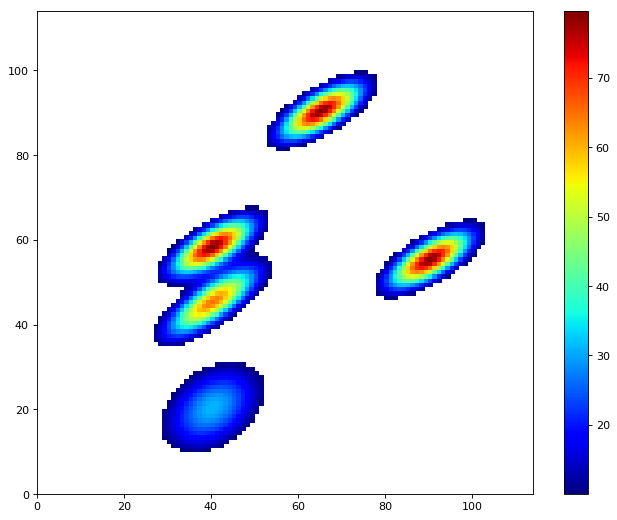

In [5]:
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
g_len = 115
grid = np.zeros((2, g_len, g_len))
labels = np.zeros((2, g_len, g_len), dtype=int)
x, y = np.meshgrid(np.arange(g_len), np.arange(g_len))
coords = np.dstack((x, y))
peak1_t0 = 1e4 * multivariate_normal(mean=[40, 45], cov=np.array([[50, 30], [30, 30]])).pdf(coords)
peak2_t0 = 1e4 * multivariate_normal(mean=[40, 58], cov=np.array([[40, 20], [20, 20]])).pdf(coords)
peak3_t0 = 1e4 * multivariate_normal(mean=[65, 90], cov=np.array([[40, 20], [20, 20]])).pdf(coords)
peak4_t0 = 1e4 * multivariate_normal(mean=[90,55], cov=np.array([[40, 20], [20, 20]])).pdf(coords)
peak5_t0 = 1e4 * multivariate_normal(mean=[40,20], cov=np.array([[60, 20], [20, 50]])).pdf(coords) 

peak1_t1 = 1e4 * multivariate_normal(mean=[50, 55], cov=np.array([[50, 30], [30, 30]])).pdf(coords)
peak2_t1 = 1e4 * multivariate_normal(mean=[45, 70], cov=np.array([[40, 20], [20, 20]])).pdf(coords)
peak3_t1 = 1e4 * multivariate_normal(mean=[75, 110], cov=np.array([[40, 20], [20, 20]])).pdf(coords)
peak4_t1 = 1e4 * multivariate_normal(mean=[95,65], cov=np.array([[40, 20], [20, 20]])).pdf(coords)
peak5_t1 = 1e4 * multivariate_normal(mean=[50, 30], cov=np.array([[60, 20], [20, 50]])).pdf(coords) 

grid[0] +=  peak1_t0+peak2_t0+peak3_t0+peak4_t0+peak5_t0
grid[1] +=  peak1_t1+peak2_t1+peak3_t1+peak4_t1+peak5_t1

plt.pcolormesh(x, y, np.ma.array(grid[0], mask=grid[0] < 10), cmap='jet', )
plt.colorbar()


# Object Identification

Let's start with a generic 2D field of quasi-discrete peaks (see above). These peaks could represent updraft helicity associated with severe storms, radar reflectivity, or intense rainfall regions, etc. MontePython can identifying this regions using a single threshold or with the more sophisicated enhanced watershed algorithm (Lakshmanan et al. 2009, Gagne et al. 2016). 

### Single Threshold Method

To use the single threshold method, set `method = single_threshold` and `params = {'bdry_thresh':N}` where `N` is the given threshold. Set `return_object_properties = True` if you also want to return various properties of the labelled objects. For this example, `return_object_properties` is set to `False` since we only want the object labels. In the first example, the boundary threshold is 20. 

In [4]:
storm_labels = label( input_data = grid[0],
                                           method ='single_threshold', 
                                           return_object_properties=False, 
                                           params = {'bdry_thresh':20} )

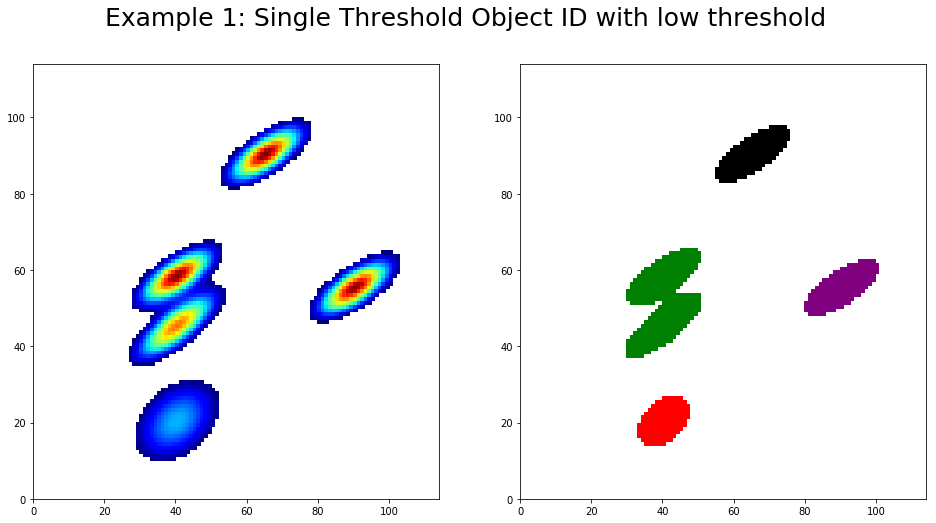

In [5]:
fig, axs = plt.subplots(1,2, figsize=(16,8))
fig.suptitle('Example 1: Single Threshold Object ID with low threshold', fontsize=25)
axs[0].pcolormesh(x, y, np.ma.array(grid[0], mask=grid[0] < 10), cmap='jet')
axs[1].pcolormesh(x,y, storm_labels, cmap=cmap)

The single threshold method performs well for discrete features, but may not separate clustered objects (e.g., the green object). Separating these features requires a higher threshold (see below). However, increasing the threshold 
can be restrictive (e.g., the slightly weaker object closest to the SW corner is no longer identified). Ultimately, there are pros and cons to the single threshold method. 



In [6]:
storm_labels = label( grid[0], 
                      method ='single_threshold', 
                      return_object_properties=False, 
                      params = {'bdry_thresh':40} )

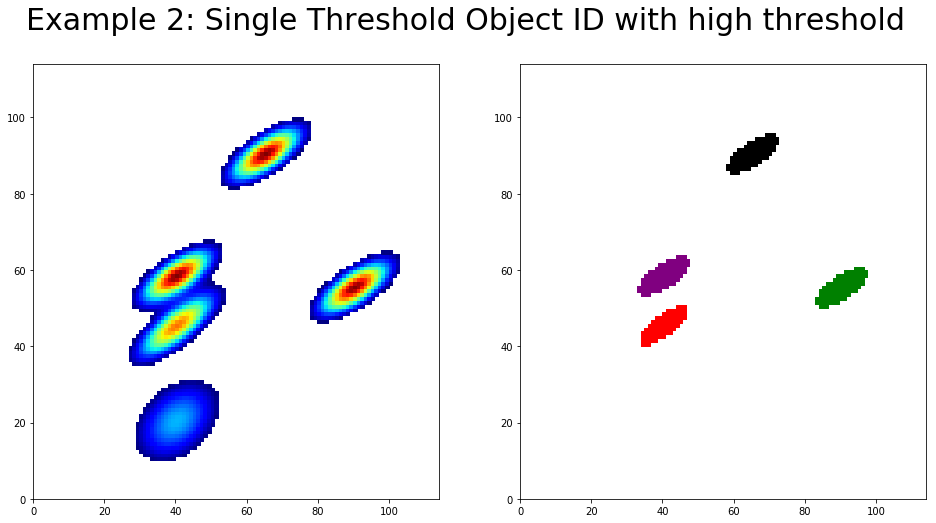

In [7]:
fig, axs = plt.subplots(1,2, figsize=(16,8))
fig.suptitle('Example 2: Single Threshold Object ID with high threshold', fontsize=30)
axs[0].pcolormesh(x, y, np.ma.array(grid[0], mask=grid[0] < 10), cmap='jet')
axs[1].pcolormesh(x,y, storm_labels, cmap=cmap)

## Enhanced Watershed Method

A more sophisicated alternative is the enhanced watershed algorithm. The watershed method identifies local maxima and then grows objects pixel by pixel from a quantized version of the original field until they reach a specified area or intensity criteria (Lakshmanan et al. 2009). Objects are restricted from growing into regions less than the given minimum threshold (e.g., reflectivity > 40 dBZ) and once an object is identified, a larger region surrounding the objects is demarcated as a no-grow region for additional objects ensuring separation (i.e., the foothills region in
Lakshmanan et al. 2009). Thus, the enhanced watershed algorithm is most powerful for identifying separate objects from clusters. However, the watershed algorithm does requires careful tuning to outperform the single threshold method. The different sensitivities and limitations of the watershed algorithm are provided in section 2c1 of Flora et al. (2019). In summary, the crucial parameters for the watershed algorithm are the minimum (`min_thresh`) and size (`size_threshold_pixels`) thresholds. 

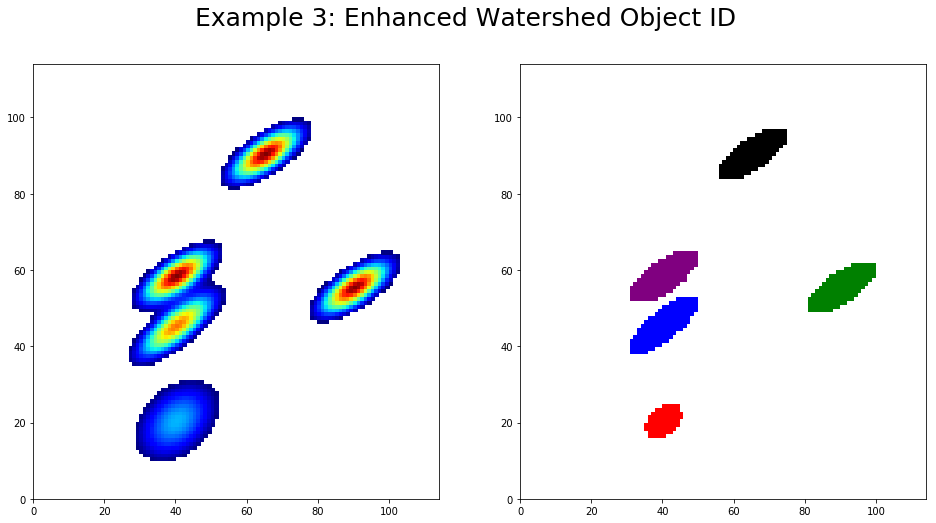

In [8]:
storm_labels = label(  input_data = grid[0], 
                       method ='watershed', 
                       return_object_properties=False, 
                       params = {'min_thresh':25,
                                 'max_thresh':80,
                                 'data_increment':20,
                                 'delta':15,
                                 'size_threshold_pixels': 150,
                                 'local_max_area':50} )
fig, axs = plt.subplots(1,2, figsize=(16,8))
fig.suptitle('Example 3: Enhanced Watershed Object ID', fontsize=25)
axs[0].pcolormesh(x, y, np.ma.array(grid[0], mask=grid[0] < 10), cmap='jet')
axs[1].pcolormesh(x,y, storm_labels, cmap=cmap)

# Object Matching

For object matching, MontePython uses the total interest score from Skinner et al. (2018)
<br>
<br>
<h3><center>$T = \frac{1}{2} \Big( \frac{c_{max} - c}{c_{max}} + \frac{m_{max} - m}{m_{max}} \Big)\frac{t_{max} - t}{t_{max}}  $</center></h3>
<br>
<br>
where $c$ is the centroid displacement between an object pair, $m$ is the minimum displacement between an object pair, and $t$ is timing displacement between an object pair with the subscript $max$ indicating the maximum allowable displacement for the three variables. As we can infer from the equation above, it is possible match objects from different times in MontePython. 

Let's match two generic object sets together (e.g., forecasted vs. observed reflectivity objects). In both Skinner et al. (2018) and Flora et al. (2019), the `cent_dist_max` and `min_dist_max` were set to the same value (note the value is in units of gridpoints). We are not match objects from different times so set `time_max=0`. Non-unique matching is possible in MontePython where multiple objects in one set can be matched to a single object in another set. For this example, we want unique (or one-to-one) matching, so set `one_to_one = True`. Lastly, `score_thresh` sets the minimum total interest score for a potential object pair. 


In [14]:
from ObjectMatching import ObjectMatching
obj_match = ObjectMatching(cent_dist_max = 10, 
                           min_dist_max = 10, 
                           time_max=0, 
                           score_thresh=0.2, 
                           one_to_one = True)

1


In [19]:
# Label the objects in the first grid
labels_0, labels_props0 = label( grid[0], 
                                method ='watershed', 
                                return_object_properties=True, 
                                params = {'min_thresh':25,
                                          'max_thresh':80,
                                          'data_increment':20,
                                          'delta':15,
                                          'size_threshold_pixels': 150,
                                          'local_max_area':50} )

# Label the objects in the second grid 
labels_1, labels_props1 = label( grid[1], 
                                 method ='watershed', 
                                 return_object_properties=True, 
                                 params = {'min_thresh':25,
                                           'max_thresh':80,
                                           'data_increment':20,
                                           'delta':15,
                                           'size_threshold_pixels': 150,
                                           'local_max_area':50} )
# Match the objects 
matched_0, matched_1, _ = obj_match.match_objects(labels_0, labels_1)

In [20]:
# The corresponding elements of matched_0 and matched_1 are the pairs from labels_0 and labels_1
print matched_0, matched_1

[2, 3, 4, 1] [2, 3, 4, 1]


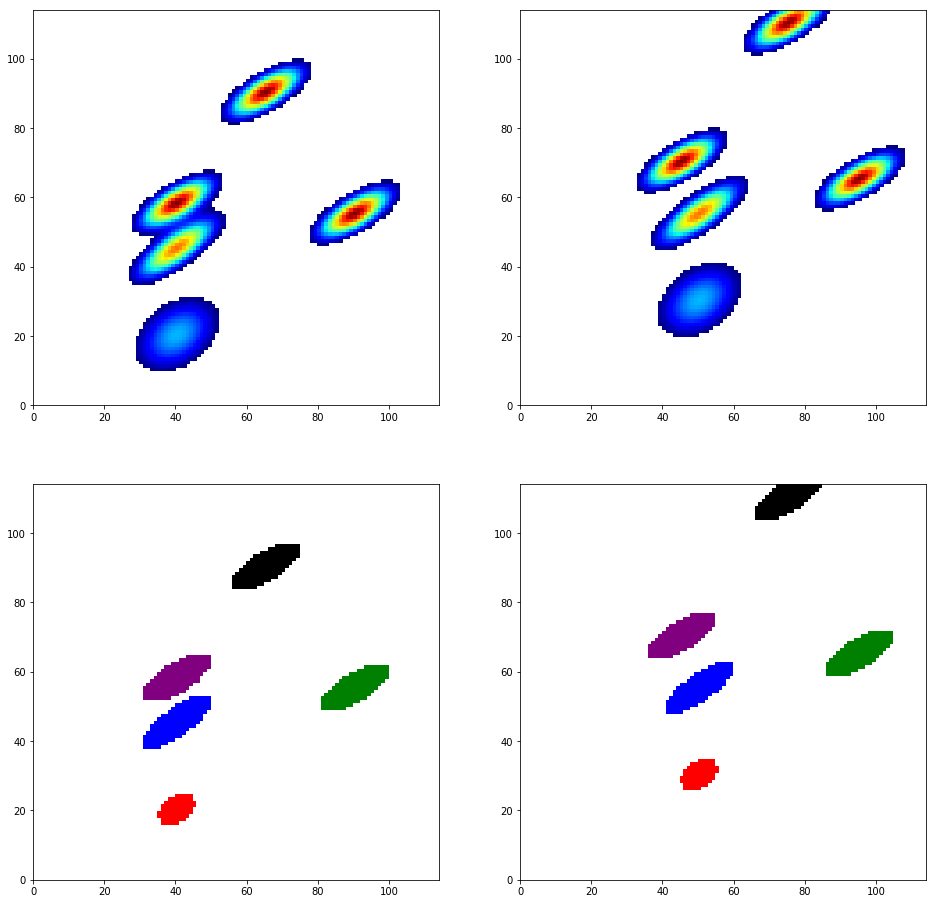

In [26]:
fig, axs = plt.subplots(2,2, figsize=(16,16))
axs[0,0].pcolormesh(x, y, np.ma.array(grid[0], mask=grid[0] < 10), cmap='jet')
axs[0,1].pcolormesh(x, y, np.ma.array(grid[1], mask=grid[1] < 10), cmap='jet')
axs[1,0].pcolormesh(x, y, labels_0, cmap=cmap)
axs[1,1].pcolormesh(x, y, labels_1, cmap=cmap)

In [17]:
def get_centroid_coords(label_props):
    '''Creates a dictionary with the object labels as keys 
    and the tuple of centroid coordinates as items'''
    centroids = {}
    for region in label_props:
        centroids[region.label] = region.centroid
    return centroids
        
label_cent_0 = get_centroid_coords(labels_props0)    
label_cent_1 = get_centroid_coords(labels_props1)

def matching_path(label_cent_0, label_cent_1, matched_0, matched_1):
    '''Associate matched objects and create their matching path'''
    x_set = []
    y_set = []
    for label_0, label_1 in zip(matched_0, matched_1):
        cent_0 = label_cent_0[label_0]
        cent_1 = label_cent_1[label_1]
        
        x1 = (cent_0[1], cent_1[1])
        y1 = (cent_0[0], cent_1[0])
        x_set.append(x1)
        y_set.append(y1)
    return x_set, y_set
    
x_set, y_set = matching_path(label_cent_0, label_cent_1, matched_0, matched_1)

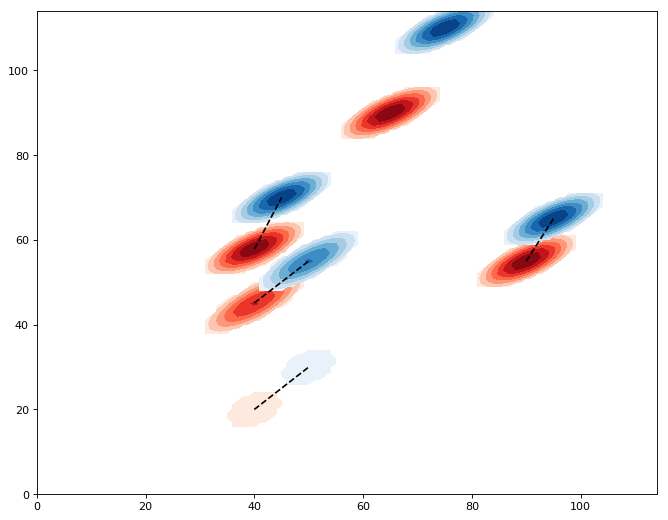

In [13]:
# Plot the matching path
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
x, y = np.meshgrid(np.arange(g_len), np.arange(g_len))
plt.contourf(x, y, np.ma.array(grid[0], mask=labels_0 == 0), cmap='Reds')
plt.contourf(x, y, np.ma.array(grid[1], mask=labels_1 == 0), cmap='Blues')
for x1, y1 in zip(x_set, y_set):
    plt.plot(x1,y1, linestyle='dashed', color='k')
